<a href="https://colab.research.google.com/github/williammcintosh/PLM_sentiment-analysis/blob/main/PLM_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with PLM Sentence Embeddings

## Author

Will McIntosh
11/6/2023

## Goal

Use pre-trained language models (PLM) (Bert & GPT-2) to predict sentiment scores of Amazon review data [collected from Kaggle](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews). I do this by converting the text from the review titles into numerical data (vectors, embeddings) that can be understood by classification models (MLP).


## Process

1. Use the AutoTokenizer and AutoModel classes from the transformers library to load the tokenizer and model for the specified model_name
2. Convert the text into vector representations (embeddings). Sentences are tokenized in batches and then passed to the model to obtain embeddings.
The embeddings are obtained by averaging the last hidden states of the outputs from the model (mean pooling).
3. Incorporate a training loop that adjusts the model's weights based on the gradients calculated from the dataset. We fine-tune the models using the transformers library and PyTorch.
3. Use StandardScaler from sklearn.preprocessing to scale the sentence embeddings for MLP Classifier.

## Obstacles

1. Using Colab's Free version took me about five hours to run. Something was wrong. Our professor [Ameeta Agrawal](https://scholar.google.com/citations?user=1XYgV6kAAAAJ&hl=en) asked in class "which layer are we extracting our representations from to use for our text classification?" I found out through some searching, stumbled upon this [SubStack post on fine tuning](https://magazine.sebastianraschka.com/i/115943216/finetuning-i-updating-the-output-layers) which talks about freezing parameters to prevent training the entire PLM and to only update the outer layer. This changed the time from five hours to two hours.
```python
# freeze all layers
for param in model.parameters():
    param.requires_grad = False
# then unfreeze the two last layers (output layers)
for param in model.pre_classifier.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True
```
1. Moving the model over to a GPU with the line `model.to(device)`.
2. Padding Tokens because the tokenizer for GPT-2 is expecting a padding tokenization but does not have one by default. I had to create one manually with the help of [Stack Overflow](https://stackoverflow.com/a/73137031).


# Results

* BERT got an F1-Score of 0.839
* GPT-2 got an F1-Score of 0.925

# Discussion

* I thought it was interesting that GPT-2 did better than BERT because GPT-2 is a decoder model while BERT is an encoder model. I'd expect that BERT as an encoder model would do better than GPT-2 for this text classification.

# Imports

## Libraries

In [ ]:
%%capture

# Importing, reading, and manipulating data
import sys, os
import pandas as pd
import numpy as np

# Classification
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier

# PLM tokenization
! pip install transformers[torch]
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import GPT2Tokenizer, GPT2TokenizerFast, GPT2Config, GPT2ForSequenceClassification, BertForSequenceClassification
import torch

# Fine-tuning metric
from sklearn.metrics import precision_recall_fscore_support
! pip install datasets
from datasets import Dataset
from functools import partial


# For visualization
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Datasets

In [ ]:
%%capture

# downloads the .csv files from google drive only if it's not already in directory
if os.path.isfile("/content/sentiment_test.json") == False:
  !gdown --id 19E5coDtorvq1Q4J6ffBKNkYuR4XPTBCU

test_df = pd.read_json("/content/sentiment_test.json", lines=True)
test_df = test_df[['stars', 'review_title']]

In [ ]:
%%capture

if os.path.isfile("/content/sentiment_train.json") == False:
  !gdown --id 1J0RI7P21n4hpcxI8t9Dx-vOMkVjDQqlg

train_df = pd.read_json("/content/sentiment_train.json", lines=True)
train_df = train_df[['stars', 'review_title']]

In [ ]:
train_df.shape

(80000, 2)

# Data

## Examination

In [ ]:
train_df.head()

,stars,review_title
0,1,I'll spend twice the amount of time boxing up ...
1,1,Not use able
2,1,The product is junk.
3,1,Fucking waste of money
4,1,bubble


In [ ]:
train_df.head(10).to_csv()

",stars,review_title\n0,1,I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...\n1,1,Not use able\n2,1,The product is junk.\n3,1,Fucking waste of money\n4,1,bubble\n5,1,Poor quality. The material was fuzzy from day one\n6,1,Not reliable ☹️\n7,1,Waste of money\n8,1,Picture Doesn’t Represent Well\n9,1,Collapses on itself\n"

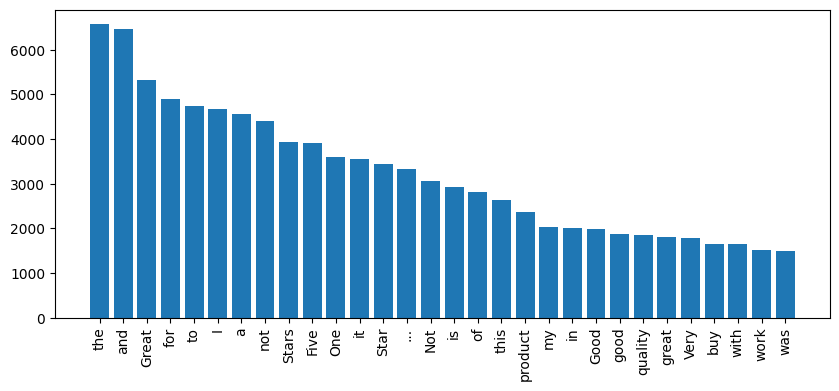

In [ ]:
words = train_df['review_title'].str.split().explode().reset_index(drop=True)
word_counts = words.value_counts().head(30)
plt.figure(figsize=(10, 4))
plt.bar(word_counts.index, word_counts.values)
plt.xticks(rotation=90); plt.show()

In [ ]:
train_df.value_counts(['stars'])

stars
1        40000
5        40000
dtype: int64

In [ ]:
test_df.head()

,stars,review_title
0,1,Don’t waste your time!
1,1,One Star
2,1,Totally useless
3,1,Gold filled earrings
4,1,Poor container


# Training

In [ ]:
# Used during the training process
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Tokenizes and pads based on the longest thread / review.
# Convert the labels to integers representing class indices.
def tokenize_and_encode(examples, tokenizer, max_length):
    tokenized_inputs = tokenizer(examples['review_title'], padding='max_length', truncation=True, max_length=max_length)
    tokenized_inputs['labels'] = [int(star) for star in examples['stars']]
    return tokenized_inputs


# This will group the dataset by 'stars' and then sample a fraction from each group.
def select_portion_from_each_class(df, portion):
    return df.groupby('stars').apply(lambda x: x.sample(frac=portion)).reset_index(drop=True)


def freeze_layers(model_name, model):
    # Freeze all layers in the model
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the classifier head depending on the model type
    if "bert-base-uncased" in model_name:
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif "distilgpt2" in model_name:
        # Unfreeze last n transformer layers (for example 2 layers)
        for i in range(1, 3):
            for param in model.transformer.h[-i].parameters():
                param.requires_grad = True
        # Unfreeze the classification head which is not 'lm_head' but 'score' in this case
        for param in model.score.parameters():
            param.requires_grad = True


def Make_Predictions(train_df, test_df, model_name='bert-base-uncased', portion=0.35):

    torch.cuda.empty_cache()

    # Select a portion of the datapoints from each class
    train_df = select_portion_from_each_class(train_df, portion=portion)
    test_df = select_portion_from_each_class(test_df, portion=portion)

    # Update labels from 1,5 to 0,1 for binary classification.
    train_df['stars'] = train_df['stars'].replace({1: 0, 5: 1})
    test_df['stars'] = test_df['stars'].replace({1: 0, 5: 1})

    # Initialize tokenizer and model for sequence classification
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Check if the model is GPT-2 based and set the padding token if necessary
    if "gpt2" in model_name:
        configuration = GPT2Config.from_pretrained(model_name, num_labels=2)
        model = GPT2ForSequenceClassification.from_pretrained(model_name, config=configuration)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Make sure that the pad token is set to the eos token
        tokenizer.pad_token = tokenizer.eos_token  # This line ensures that padding token is set
        model.config.pad_token_id = tokenizer.eos_token_id  # This line ensures that the model knows the padding token ID
    elif "bert-base-uncased" in model_name:
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    freeze_layers(model_name, model)

    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Ensure tokenizer has token padding set
    if "gpt2" in model_name and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Tokenize and encode datasets
    max_length = 64
    tokenized_train_dataset = train_dataset.map(
        lambda examples: tokenize_and_encode(examples, tokenizer=tokenizer, max_length=max_length),
        batched=True,
        # num_proc=4
    )
    tokenized_test_dataset = test_dataset.map(
        lambda examples: tokenize_and_encode(examples, tokenizer=tokenizer, max_length=max_length),
        batched=True,
        # num_proc=4
    )

    # Moving model training data over to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Testing
    print(f"Is a GPU available: {torch.cuda.is_available()}")
    print(f"Is this instance using a GPU?: {next(model.parameters()).is_cuda}")
    print(f"Model Parameters: {filter(lambda p: p.requires_grad, model.parameters())}")
    print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Tokenizer Padding: {tokenizer.pad_token}")

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,              # number of training epochs
        per_device_train_batch_size=4,   # batch size for training
        per_device_eval_batch_size=4,   # batch size for evaluation
        warmup_steps=0,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    trainer.train()

    # Evaluate the model
    metrics = trainer.evaluate()

    print(metrics)


# Classifiers

### MLP + BERT

In [ ]:
Make_Predictions(train_df, test_df, model_name='bert-base-uncased')

Map:   0%|          | 0/28000 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Is a GPU available: True
Is this instance using a GPU?: True
Model Parameters: <filter object at 0x7c766a7fd480>
Trainable Parameters: 1538
Tokenizer Padding: [PAD]


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.588300,0.577847,0.820513,0.840655,0.822857
2,0.553600,0.529964,0.838516,0.839039,0.838571


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.588300,0.577847,0.820513,0.840655,0.822857
2,0.553600,0.529964,0.838516,0.839039,0.838571
3,0.535800,0.516320,0.839979,0.840178,0.840000


{'eval_loss': 0.5163200497627258, 'eval_f1': 0.8399790993109304, 'eval_precision': 0.8401777255055702, 'eval_recall': 0.84, 'eval_runtime': 3.7203, 'eval_samples_per_second': 188.155, 'eval_steps_per_second': 47.039, 'epoch': 3.0}


### MLP + GPT-2

In [ ]:
Make_Predictions(train_df, test_df, model_name='distilgpt2')

Map:   0%|          | 0/28000 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Is a GPU available: True
Is this instance using a GPU?: True
Model Parameters: <filter object at 0x7c7669b746a0>
Trainable Parameters: 14177280
Tokenizer Padding: <|endoftext|>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.329200,0.499222,0.898525,0.899305,0.898571


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.329200,0.499222,0.898525,0.899305,0.898571
2,0.274300,0.427528,0.922806,0.923979,0.922857
3,0.314700,0.424507,0.925699,0.926062,0.925714


{'eval_loss': 0.4245074987411499, 'eval_f1': 0.9256991222698508, 'eval_precision': 0.9260620915032679, 'eval_recall': 0.9257142857142857, 'eval_runtime': 1.8527, 'eval_samples_per_second': 377.834, 'eval_steps_per_second': 94.458, 'epoch': 3.0}
